v2 of Algonauts Projects with extended procedures and approaches

**Step 0: Checking environment setup and importing required libraries**

In [1]:
# Checking GPU availability and properties using PyTorch

import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")

if cuda_available:
    # Get the number of CUDA devices
    n_cuda_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {n_cuda_devices}")
    
    # Print information for each CUDA device
    for i in range(n_cuda_devices):
        device_props = torch.cuda.get_device_properties(i)
        print(f"\nCUDA Device {i}:")
        print(f"  Name: {device_props.name}")
        print(f"  Compute Capability: {device_props.major}.{device_props.minor}")
        print(f"  Total Memory: {device_props.total_memory / 1024**3:.2f} GB")
        
    # Get current device information
    current_device = torch.cuda.current_device()
    print(f"\nCurrent CUDA device: {current_device}")
else:
    print("No CUDA devices found. PyTorch will run on CPU only.")

CUDA is available: True
Number of CUDA devices: 1

CUDA Device 0:
  Name: NVIDIA GeForce RTX 4050 Laptop GPU
  Compute Capability: 8.9
  Total Memory: 6.00 GB

Current CUDA device: 0


In [2]:
# Checking system configuration
import sys
import subprocess
import torch

def check_nvidia_gpu():
    try:
        # Try to get GPU info using nvidia-smi
        output = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
        return output.decode('utf-8')
    except:
        return "No NVIDIA GPU detected or nvidia-smi not found"

print("System Information:")
print("-" * 50)
print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print("\nGPU Information:")
print("-" * 50)
print(check_nvidia_gpu())

System Information:
--------------------------------------------------
Python Version: 3.11.0
PyTorch Version: 2.7.1+cu118
CUDA Available: True
CUDA Version: 11.8

GPU Information:
--------------------------------------------------
Sat Sep 20 10:58:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.29                 Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |


In [3]:
# Importing the required libraries (the most fun part of all the code)

import os
import json
import math
import shutil
import time
from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import h5py
import torch
import librosa
import ast
import string
import zipfile
from tqdm.notebook import tqdm
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import cv2
import nibabel as nib
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import ipywidgets as widgets
from ipywidgets import VBox, Dropdown, Button
from IPython.display import Video, display, clear_output
from moviepy.editor import VideoFileClip
from transformers import BertTokenizer, BertModel
from torchvision.transforms import Compose, Lambda, CenterCrop
from torchvision.models.feature_extraction import create_feature_extractor
from omegaconf import DictConfig, OmegaConf

Step 1: Understanding Challenge Data (Based on starter notebook)

The challenge data comes from the CNeuroMod dataset, and consists of multimodal movie stimuli and corresponding whole-brain time series fMRI responses of four subjects. Challenge participants will train and evaluate their encoding models using a subset of CNeuroMod's data which includes almost 80 hours of multimodal movie stimuli and corresponding fMRI responses. The stimuli consist of movie visual frames, audio samples, and time-stamped language transcripts. The neural data consist of whole-brain fMRI responses for four CNeuroMod subjects (sub-01, sub-02, sub-03 and sub-05), normalized to the Montreal Neurological Institute (MNI) spatial template (Brett et al., 2002), and processed as time series whose signal is assigned to 1,000 functionally defined brain parcels (Schaefer et al., 2018).

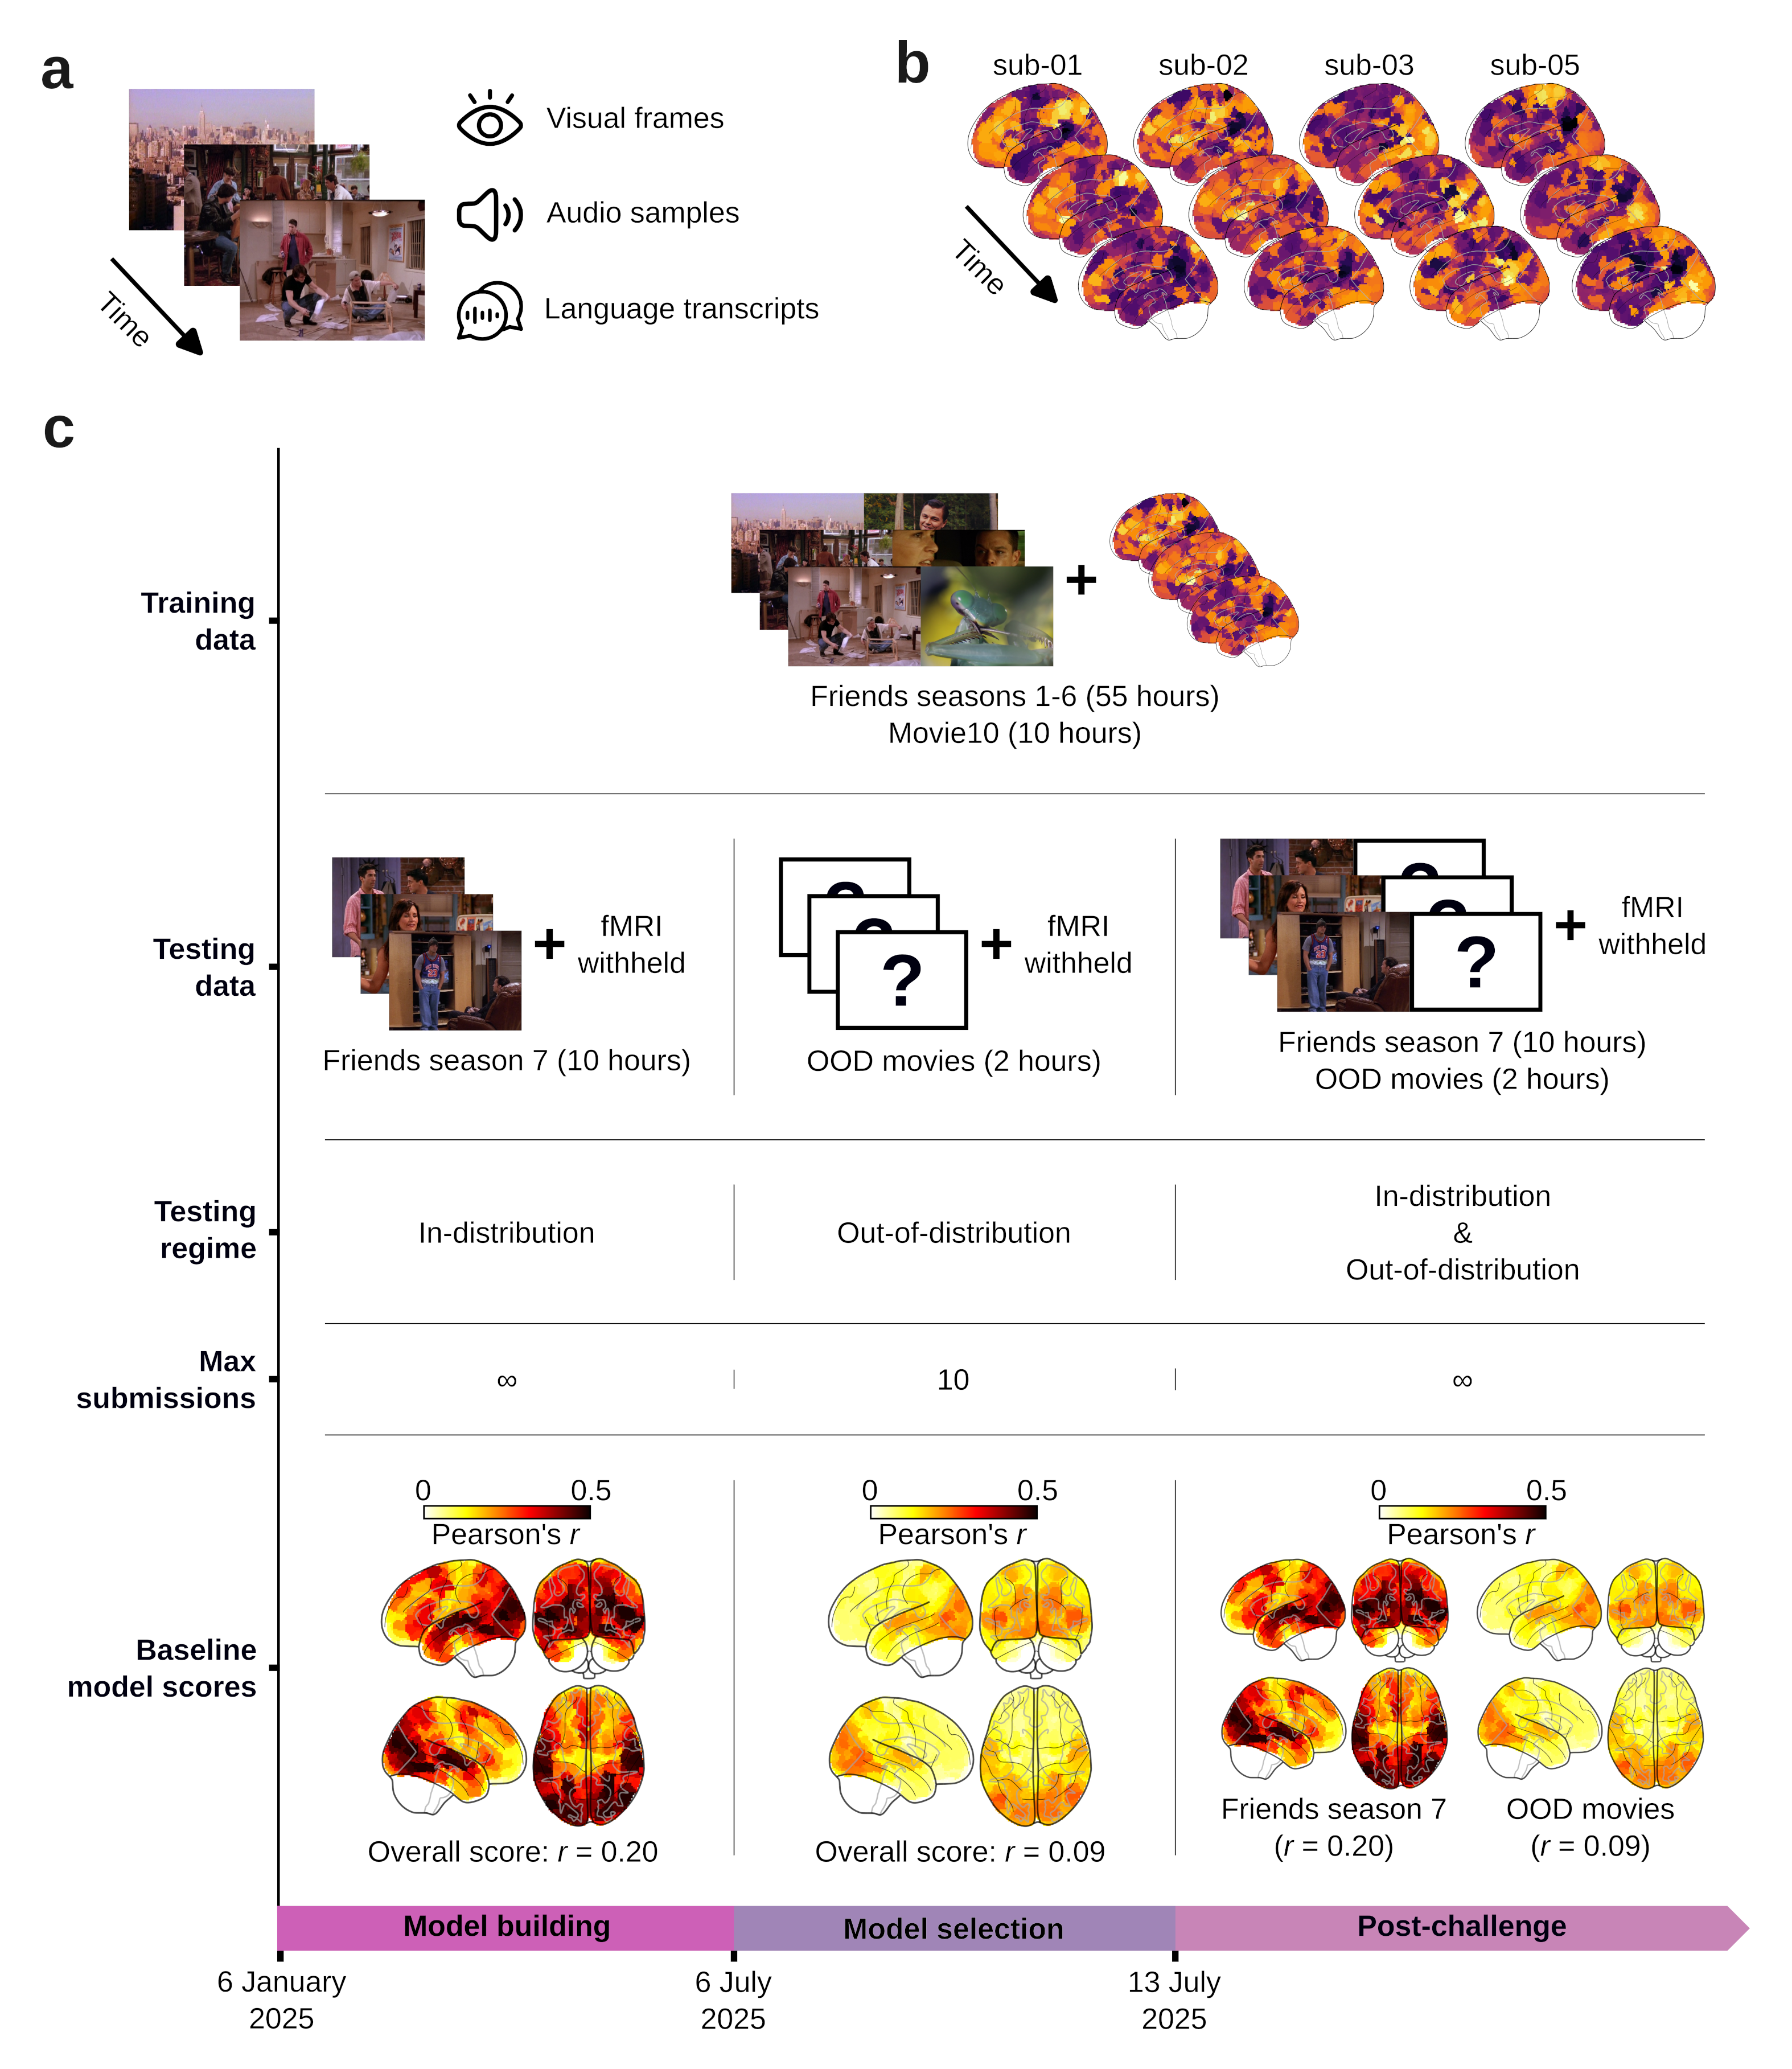

Multimodal movie stimuli
The multimodal (audio, visual and language) stimuli of the Algonauts 2025 challenge consist of .mkv files of audiovisual movies, and of .tsv files that contain corresponding timestamped movie transcripts.

.mkv files (audiovisual movie stimuli)
The .mkv files consist of movies that combine the visual and audio modalities, for seasons 1 to 7 of Friends and for Movie10.

Friends (seasons 1-7)
The .mkv files for seasons 1 to 7 of Friends are found at ../algonauts_2025.competitors/stimuli/movies/friends/s<season>/, and have the naming convention friends_s-<season>e<episode><episode_split>.mkv, where:

season: Number indicating the Friends season.
episode: Number indicating the Friends episode.
episode_split: Full episodes were split into shorter (~12 min) segments watched by participants inside the MRI in order to reduce the duration of fMRI data acquisition runs. Letters indicate the split of each episode. Most Friends episodes are split into two parts (i.e., splits a and b), but a handful of longer episodes are split into four parts (i.e., splits a, b, c and d).
Movie10
The .mkv files for Movie10 are found at ../algonauts_2025.competitors/stimuli/movies/movie10/<movie>/, and have the naming convention <movie><movie_split>.mkv, where:

movie: String indicating the movie name.
movie_split: Number indicating the movie split. Each movie was split into several segments to limit the duration of consecutive fMRI data acquisition runs.

.tsv files (timestamped movie transcripts)
The .tsv files contain the timestamped movie transcripts, that is, transcripts of spoken content (dialogue) in the movie stimuli, for seasons 1 to 7 of Friends and for Movie10.

Friends (seasons 1-7)
The .tsv files for seasons 1 to 7 of Friends are found at ../algonauts_neuromod.competitors/stimuli/transcripts/friends/s<season>/, and have the naming convention friends_s-<season>e<episode><episode_split>.tsv, where:

season: Number indicating the Friends season.
episode: Number indicating the Friends episode.
episode_split: Letter indicating the split of the episode. Most Friends episodes are split into two parts (i.e., splits a and b), but a handful of longer episodes are split into four parts (i.e., splits a, b, c and d).
Movie10
The .tsv files for Movie10 are found at ../algonauts_neuromod.competitors/stimuli/transcripts/movie10/<movie>/, and have the naming convention movie10_<movie><movie_split>.tsv, where:

movie: String indicating the movie name.
movie_split: Number indicating the movie split.
.tsv file content
The .tsv files splits transcribed movie dialogue into chunks of 1.49 seconds, where each row of the .tsv file corresponds to one such chunk. This segmentation was performed to facilitate alignment with the fMRI data, since fMRI volumes were acquired with a repetition time (TR) of 1.49 seconds (that is, one fMRI sample was acquired every 1.49 seconds). If no words were spoken during a specific chunk, the corresponding .tsv file row will be empty.

The columns of the .tsv files consist of different attributes of the language transcripts:

text_per_tr: Sentence consisting of words that were spoken during the chunk of interest (i.e., words with word offset within the chunk of interest, even if their onset was in the previous chunk).
words_per_tr: List of individual words that were spoken during the chunk of interest.
onsets_per_tr: Starting time (in seconds) of each word spoken during the chunk, relative to movie onset.
durations_per_tr: Duration (in seconds) of each word spoken during the chunk.
NOTE: Since the transcribed movie dialogue is not split based on word onset/offset (but rather into chunks of 1.49 seconds), the onset and offset of some words might fall in different (consecutive) chunks. In case a word is split into two consecutive chunks, it will be assigned to the chunk of word offset.

**Step 2: Data Pre-Processing and Loading**

In [ ]:
# Data Loading functions to fetch .mkv and .tsv files



In [5]:
# Functions to neccessiate alignment of .mkv movies with the .tsv transcripts

def load_transcript(transcript_path):
    """
    Loads a transcript file and returns it as a DataFrame.

    Parameters
    ----------
    transcript_path : str
        Path to the .tsv transcript file.

    """
    df = pd.read_csv(transcript_path, sep='\t')
    return df


def get_movie_info(movie_path):
    """
    Extracts the frame rate (FPS) and total duration of a movie.

    Parameters
    ----------
    movie_path : str
        Path to the .mkv movie file.

    """

    cap = cv2.VideoCapture(movie_path)
    fps, frame_count = cap.get(cv2.CAP_PROP_FPS), cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()

    return fps, frame_count / fps


def split_movie_into_chunks(movie_path, chunk_duration=1.49):
    """
    Divides a video into fixed-duration chunks.

    Parameters
    ----------
    movie_path : str
        Path to the .mkv movie file.
    chunk_duration : float, optional
        Duration of each chunk in seconds (default is 1.49).

    """

    _, video_duration = get_movie_info(movie_path)
    chunks = []
    start_time = 0.0

    # Create chunks for the specified time
    while start_time < video_duration:
        end_time = min(start_time + chunk_duration, video_duration)
        chunks.append((start_time, end_time))
        start_time += chunk_duration
    return chunks

def extract_movie_segment_with_sound(movie_path, start_time, end_time,
    output_path='output_segment.mp4'):
    """
    Extracts a specific segment of a video with sound and saves it.

    Parameters
    ----------
    movie_path : str
        Path to the .mkv movie file.
    start_time : float
        Start time of the segment in seconds.
    end_time : float
        End time of the segment in seconds.
    output_path : str, optional
        Path to save the output segment (default is 'output_segment.mp4').

    """

    # Create movie segment
    movie_segment = VideoFileClip(movie_path).subclip(start_time, end_time)
    print(f"\nWriting movie file from {start_time}s until {end_time}s")

    # Write video file
    movie_segment.write_videofile(output_path, codec="libx264",
        audio_codec="aac", verbose=False, logger=None)
    return output_path


def display_transcript_and_movie(chunk_index, transcript_df, chunks,
    movie_path):
    """
    Displays transcript, movie, onset, and duration for a selected chunk.

    Parameters
    ----------
    chunk_index : int
        Index of the selected chunk.
    transcript_df : DataFrame
        DataFrame containing transcript data.
    chunks : list
        List of (start_time, end_time) tuples for video chunks.
    movie_path : str
        Path to the .mkv movie file.

    """
    # Retrieve the start and end times for the selected chunk
    start_time, end_time = chunks[chunk_index]

    # Get the corresponding transcript row if it exists in the DataFrame
    transcript_chunk = transcript_df.iloc[chunk_index] if chunk_index < len(transcript_df) else None

    # Display the stimulus chunk number
    print(f"\nChunk number: {chunk_index + 1}")

    # Display transcript details if available; otherwise, indicate no dialogue
    if transcript_chunk is not None and pd.notna(transcript_chunk['text_per_tr']):
        print(f"\nText: {transcript_chunk['text_per_tr']}")
        print(f"Words: {transcript_chunk['words_per_tr']}")
        print(f"Onsets: {transcript_chunk.get('onsets_per_tr', 'N/A')}")
        print(f"Durations: {transcript_chunk.get('durations_per_tr', 'N/A')}")
    else:
        print("<No dialogue in this scene>")

    # Extract and display the video segment
    output_movie_path = extract_movie_segment_with_sound(movie_path, start_time,
        end_time)
    display(Video(output_movie_path, embed=True, width=640, height=480))


def create_dropdown_by_text(transcript_df):
    """
    Creates a dropdown widget for selecting chunks by their text.

    Parameters
    ----------
    transcript_df : DataFrame
        DataFrame containing transcript data.

    """

    options = []

    # Iterate over each row in the transcript DataFrame
    for i, row in transcript_df.iterrows():
        if pd.notna(row['text_per_tr']):  # Check if the transcript text is not NaN
            options.append((row['text_per_tr'], i))
        else:
            options.append(("<No dialogue in this scene>", i))
    return widgets.Dropdown(options=options, description='Select scene:')


def interface_display_transcript_and_movie(movie_path, transcript_path):
    """
    Interactive interface to align movie and transcript chunks.

    Parameters
    ----------
    movie_path : str
        Path to the .mkv movie file.
    transcript_path : str
        Path to the transcript file (.tsv).

    """

    # Load the transcript data from the provided path
    transcript_df = load_transcript(transcript_path)

    # Split the video file into chunks of 1.49 seconds
    chunks = split_movie_into_chunks(movie_path)

    # Create a dropdown widget with transcript text as options
    dropdown = create_dropdown_by_text(transcript_df)

    # Create an output widget to display video and transcript details
    output = widgets.Output()

    # Display the dropdown and output widgets
    display(dropdown, output)

    # Define the function to handle dropdown value changes
    def on_chunk_select(change):
        with output:
            output.clear_output()  # Clears previous content
            chunk_index = dropdown.value
            display_transcript_and_movie(chunk_index, transcript_df, chunks,
                movie_path)

    dropdown.observe(on_chunk_select, names='value')

In [ ]:
# Align the .mkv movies and .tsv language transcripts
interface_display_transcript_and_movie(movie_path, transcript_path)

In [ ]:
# Data Loading Functions

def load_algonauts2025_friends_fmri(data_path: Path, subjects=(1, 2, 3, 5)):
    """
    Load fMRI data from Friends series for specified subjects.
    """
    fmri_data = {}
    for sub in subjects:
        sub_path = data_path / f"sub-{sub:02d}" / "fmri" / "friends"
        for fmri_file in sorted(sub_path.glob("*.npy")):
            episode = fmri_file.stem
            if episode not in fmri_data:
                fmri_data[episode] = {}
            fmri_data[episode][sub] = np.load(fmri_file)
    return fmri_data

def load_algonauts2025_movie10_fmri(data_path: Path, subjects=(1, 2, 3, 5)):
    """
    Load fMRI data from Movie10 series for specified subjects.
    """
    fmri_data = {}
    for sub in subjects:
        sub_path = data_path / f"sub-{sub:02d}" / "fmri" / "movie10"
        for fmri_file in sorted(sub_path.glob("*.npy")):
            episode = fmri_file.stem
            if episode not in fmri_data:
                fmri_data[episode] = {}
            fmri_data[episode][sub] = np.load(fmri_file)
    return fmri_data

def load_sharded_features(data_path: Path, model: str, layer: str, series: str):
    """
    Load pre-sharded features for a specific model/layer.
    """
    features = {}
    shard_path = data_path / series / model / layer
    for feat_file in sorted(shard_path.glob("*.npy")):
        episode = feat_file.stem
        features[episode] = np.load(feat_file)
    return features

def pool_features(features: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """
    Apply temporal average pooling across sequence dimension if needed.
    """
    pooled = {}
    for key, feat in features.items():
        assert feat.ndim in {2, 3}
        if feat.ndim == 3:
            feat = feat.mean(axis=1)
        pooled[key] = feat
    return pooled

def episode_filter(**kwargs):
    """
    Create a filter function for episodes based on patterns.
    """
    def filter_fn(episode: str) -> bool:
        for pattern in kwargs.get('include', []):
            if re.match(pattern, episode):
                return True
        for pattern in kwargs.get('exclude', []):
            if re.match(pattern, episode):
                return False
        return bool(kwargs.get('include', []))
    return filter_fn

In [ ]:
# Brain visualization functions with fmri data mapping to brain regions

def plot_fmri_on_brain(chunk_index, fmri_file_path, atlas_path, dataset_name,
    hrf_delay):
    """
    Map fMRI responses to brain parcels and plot it on a glass brain.

    Parameters
    ----------
    chunk_index : pandas.Series
        The selected chunk from the transcript, used to determine the fMRI
        sample.
    fmri_file_path : str
        Path to the HDF5 file containing fMRI data.
    atlas_path : str
        Path to the atlas NIfTI file.
    dataset_name : str
        Name of the dataset inside the HDF5 file.
    hrf_delay : int
        fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
        that reflects changes in blood oxygenation levels in response to
        activity in the brain. Blood flow increases to a given brain region in
        response to its activity. This vascular response, which follows the
        hemodynamic response function (HRF), takes time. Typically, the HRF
        peaks around 5–6 seconds after a neural event: this delay reflects the
        time needed for blood oxygenation changes to propagate and for the fMRI
        signal to capture them. Therefore, this parameter introduces a delay
        between stimulus chunks and fMRI samples for a better correspondence
        between input stimuli and the brain response. For example, with a
        hrf_delay of 3, if the stimulus chunk of interest is 17, the
        corresponding fMRI sample will be 20.

    """

    print(f"\nLoading fMRI file: {fmri_file_path}")

    # Load the atlas image
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()

    # Open the fMRI reeponses file, and extract the specific dataset
    with h5py.File(fmri_file_path, 'r') as f:
        print(f"Opening fMRI dataset: {dataset_name}")
        fmri_data = f[dataset_name][()]
        print(f"fMRI dataset shape: {fmri_data.shape}")

    # Extract the corresponding sample from the fMRI responses based on the
    # selected transcript chunk, and on the hrf_delay
    if (chunk_index + hrf_delay) > len(fmri_data):
        selected_sample = len(fmri_data)
    else:
        selected_sample = chunk_index + hrf_delay
    fmri_sample_data = fmri_data[selected_sample]
    print(f"Extracting fMRI sample {selected_sample+1}.")

    # Map fMRI sample values to the brain parcels in the atlas
    output_data = np.zeros_like(atlas_data)
    for parcel_index in range(1000):
        output_data[atlas_data == (parcel_index + 1)] = \
            fmri_sample_data[parcel_index]

    # Create the output NIfTI image
    output_img = nib.Nifti1Image(output_data, affine=atlas_img.affine)

    # Plot the glass brain with the mapped fMRI data
    display = plotting.plot_glass_brain(
        output_img,
        display_mode='lyrz',
        cmap='inferno',
        colorbar=True,
        plot_abs=False)
    colorbar = display._cbar
    colorbar.set_label("fMRI activity", rotation=90, labelpad=12, fontsize=12)
    plotting.show()

In [ ]:
# Main interactive interface with brain visualization
def interface_display_transcript_movie_brain(movie_path, transcript_path,
    fmri_file_path, atlas_path, dataset_name, hrf_delay):
    """
    Interactive interface to display movie and transcripts chunks along with
    the fMRI response from the corresponding sample.

    This code uses functions from Section 1.2.3.

    Parameters
    ----------
    movie_path : str
        Path to the .mkv movie file.
    transcript_path : str
        Path to the .tsv transcript file.
    fmri_file_path : str
        Path to the fMRI data file.
    atlas_path : str
        Path to the brain atlas file.
    dataset_name : str
        Name of the dataset to display fMRI data from.
    hrf_delay : int
        fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
        that reflects changes in blood oxygenation levels in response to
        activity in the brain. Blood flow increases to a given brain region in
        response its activity. This vascular response, which follows the
        hemodynamic response function (HRF), takes time. Typically, the HRF
        peaks around 5–6 seconds after a neural event: this delay reflects the
        time needed for blood oxygenation changes to propagate and for the fMRI
        signal to capture them. Therefore, this parameter introduces a delay
        between stimulus chunks and fMRI samples. For example, with a hrf_delay
        of 3, if the stimulus chunk of interest is 17, the corresponding fMRI
        sample will be 20.

    """

    # Load the .tsv transcript data from the provided path
    transcript_df = load_transcript(transcript_path)  # from 1.2.3

    # Split the .mkv movie file into chunks of 1.49 seconds
    chunks = split_movie_into_chunks(movie_path)  # from 1.2.3

    # Create a dropdown widget with transcript text as options
    dropdown = create_dropdown_by_text(transcript_df)  # from 1.2.3

    # Create an output widget to display video, transcript, and brain
    # visualization
    output = widgets.Output()

    # Define the function to handle dropdown value changes
    def on_chunk_select(change):
        with output:
            output.clear_output()  # Clear the previous output
            chunk_index = dropdown.value

            # Display video chunk and transcript
            display_transcript_and_movie(chunk_index, transcript_df, chunks,
                movie_path)  # from 1.2.3

            # Visualize brain fMRI data
            plot_fmri_on_brain(chunk_index, fmri_file_path, atlas_path,
                dataset_name, hrf_delay)

    dropdown.observe(on_chunk_select, names='value')
    display(dropdown, output)

In [ ]:
# HRF delay parameter
hrf_delay = 3  #@param {type:"slider", min:0, max:10, step:1}

root_data_dir = r"C:\Projects\algonauts 2025 data"

# Define file paths and dataset name
movie_path = root_data_dir + "/algonauts_2025.competitors/stimuli/movies/friends/s1/friends_s01e01a.mkv"
transcript_path = root_data_dir + "/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e01a.tsv"
fmri_file_path = root_data_dir + "/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
atlas_path = root_data_dir + "/algonauts_2025.competitors/fmri/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz"
dataset_name = "ses-003_task-s01e01a"

# Get the selected transcript row/chunk from the interface
interface_display_transcript_movie_brain(movie_path, transcript_path,
    fmri_file_path, atlas_path, dataset_name, hrf_delay)

**Step 3: Feature Extration of video, audio and text features**

*Video Feature Extraction*

In [ ]:
def get_vision_model(device):
    """
    Load a pre-trained slow_r50 video model and set up the feature extractor.

    Parameters
    ----------
    device : torch.device
        The device on which the model will run (i.e., 'cpu' or 'cuda').

    Returns
    -------
    feature_extractor : torch.nn.Module
        The feature extractor model.
    model_layer : str
        The layer from which visual features will be extracted.

    """

    # Load the model
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50',
        pretrained=True)

    # Select 'blocks.5.pool' as the feature extractor layer
    model_layer = 'blocks.5.pool'
    feature_extractor = create_feature_extractor(model,
        return_nodes=[model_layer])
    feature_extractor.to(device)
    feature_extractor.eval()

    return feature_extractor, model_layer

feature_extractor, model_layer = get_vision_model(device)

In [ ]:
def extract_visual_features(episode_path, tr, feature_extractor, model_layer,
    transform, device, save_dir_temp, save_dir_features):
    """
    Extract visual features from a movie using a pre-trained video model.

    Parameters
    ----------
    episode_path : str
        Path to the movie file for which the visual features are extracted.
    tr : float
        Duration of each chunk, in seconds (aligned with the fMRI repetition
        time, or TR).
    feature_extractor : torch.nn.Module
        Pre-trained feature extractor model.
    model_layer : str
        The model layer from which the visual features are extracted.
    transform : torchvision.transforms.Compose
        Transformation pipeline for processing video frames.
    device : torch.device
        Device for computation ('cpu' or 'cuda').
    save_dir_temp : str
        Directory where the chunked movie clips are temporarily stored for
        feature extraction.
    save_dir_features : str
        Directory where the extracted visual features are saved.

    Returns
    -------
    visual_features : float
        Array containing the extracted visual features.

    """

    # Get the onset time of each movie chunk
    clip = VideoFileClip(episode_path)
    start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]
    # Create the directory where the movie chunks are temporarily saved
    temp_dir = os.path.join(save_dir_temp, 'temp')
    os.makedirs(temp_dir, exist_ok=True)

    # Empty features list
    visual_features = []

    # Loop over chunks
    with tqdm(total=len(start_times), desc="Extracting visual features") as pbar:
        for start in start_times:

            # Divide the movie in chunks of length TR, and save the resulting
            # clips as '.mp4' files
            clip_chunk = clip.subclip(start, start+tr)
            chunk_path = os.path.join(temp_dir, 'visual_chunk.mp4')
            clip_chunk.write_videofile(chunk_path, verbose=False, audio=False,
                logger=None)
            # Load the frames from the chunked movie clip
            video_clip = VideoFileClip(chunk_path)
            chunk_frames = [frame for frame in video_clip.iter_frames()]

            # Format the frames to shape:
            # (batch_size, channels, num_frames, height, width)
            frames_array = np.transpose(np.array(chunk_frames), (3, 0, 1, 2))
            # Convert the video frames to tensor
            inputs = torch.from_numpy(frames_array).float()
            # Preprocess the video frames
            inputs = transform(inputs).unsqueeze(0).to(device)

            # Extract the visual features
            with torch.no_grad():
                preds = feature_extractor(inputs)
            visual_features.append(np.reshape(preds[model_layer].cpu().numpy(), -1))

            # Update the progress bar
            pbar.update(1)

    # Convert the visual features to float32
    visual_features = np.array(visual_features, dtype='float32')

    # Save the visual features
    #out_file_visual = os.path.join(
    #    save_dir_features, f'friends_s01e01a_features_visual.h5')
    #with h5py.File(out_file_visual, 'a' if Path(out_file_visual).exists() else 'w') as f:
    #    group = f.create_group("s01e01a")
    #    group.create_dataset('visual', data=visual_features, dtype=np.float32)
    #print(f"Visual features saved to {out_file_visual}")

    # Output
    return visual_features

In [ ]:
# As an exemple, extract visual features for season 1, episode 1 of Friends
episode_path = root_data_dir + "/algonauts_2025.competitors/stimuli/movies/friends/s1/friends_s01e01a.mkv"

# Duration of each movie chunk, aligned with the fMRI TR of 1.49 seconds
tr = 1.49

# Saving directories
save_dir_temp = "./visual_features"
save_dir_features = root_data_dir +  "/stimulus_features/raw/visual/"

# Execute visual feature extraction
visual_features = extract_visual_features(episode_path, tr, feature_extractor,
    model_layer, transform, device, save_dir_temp, save_dir_features)

In [ ]:
# Print the features shape
print("Visual features shape for 'friends_s01e01a.mkv':")
print(visual_features.shape)
print('(Movie samples × Visual features length)')

# Visualize the features for five movie chunks
print("\nVisual feature vectors for 5 movie chunks:\n")
print(visual_features[20:25])

*Audio Feature Extraction*

In [ ]:
def extract_audio_features(episode_path, tr, sr, device, save_dir_temp,
    save_dir_features):
    """
    Extract audio features from a movie using Mel-frequency cepstral
    coefficients (MFCCs).

    Parameters
    ----------
    episode_path : str
        Path to the movie file for which the audio features are extracted.
    tr : float
        Duration of each chunk, in seconds (aligned with the fMRI repetition
        time, or TR).
    sr : int
        Audio sampling rate.
    device : str
        Device to perform computations ('cpu' or 'gpu').
    save_dir_temp : str
        Directory where the chunked movie clips are temporarily stored for
        feature extraction.
    save_dir_features : str
        Directory where the extracted audio features are saved.

    Returns
    -------
    audio_features : float
        Array containing the extracted audio features.

    """

    # Get the onset time of each movie chunk
    clip = VideoFileClip(episode_path)
    start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]
    # Create the directory where the movie chunks are temporarily saved
    temp_dir = os.path.join(save_dir_temp, 'temp')
    os.makedirs(temp_dir, exist_ok=True)

    # Empty features list
    audio_features = []

    ### Loop over chunks ###
    with tqdm(total=len(start_times), desc="Extracting audio features") as pbar:
        for start in start_times:

            # Divide the movie in chunks of length TR, and save the resulting
            # audio clips as '.wav' files
            clip_chunk = clip.subclip(start, start+tr)
            chunk_audio_path = os.path.join(temp_dir, 'audio_s01e01a.wav')
            clip_chunk.audio.write_audiofile(chunk_audio_path, verbose=False,
                logger=None)
            # Load the audio samples from the chunked movie clip
            y, sr = librosa.load(chunk_audio_path, sr=sr, mono=True)

            # Extract the audio features (MFCC)
            mfcc_features = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
            audio_features.append(mfcc_features)
            # Update the progress bar
            pbar.update(1)

    ### Convert the visual features to float32 ###
    audio_features = np.array(audio_features, dtype='float32')

    # Save the audio features
    #out_file_audio = os.path.join(
    #    save_dir_features, f'friends_s01e01a_features_audio.h5')
    #with h5py.File(out_file_audio, 'a' if Path(out_file_audio).exists() else 'w') as f:
    #    group = f.create_group("s01e01a")
    #    group.create_dataset('audio', data=audio_features, dtype=np.float32)
    #print(f"Audio features saved to {out_file_audio}")

    ### Output ###
    return audio_features

In [ ]:
# As an example, extract audio features using season 1, episode 1 of Friends
episode_path = root_data_dir + "/algonauts_2025.competitors/stimuli/movies/friends/s1/friends_s01e01a.mkv"

# Duration of each movie chunk, aligned with the fMRI TR of 1.49 seconds
tr = 1.49

# Audio sampling rate
sr = 22050

# Saving directories
save_dir_temp = "./audio_features"
save_dir_features = root_data_dir +  "/stimulus_features/raw/audio/"

# Execute audio feature extraction
audio_features = extract_audio_features(episode_path, tr, sr, device,
    save_dir_temp, save_dir_features)

In [ ]:
# Print the features shape
print("Audio features shape for 'friends_s01e01a.mkv':")
print(audio_features.shape)
print('(Movie samples × Audio features length)')

# Visualize the features for five movie chunks
print("\nAudio feature vectors for 5 movie chunks:\n")
print(audio_features[20:25])

*Text Feature Extraction*

In [ ]:
def get_language_model(device):
    """
    Load a pre-trained bert-base-uncased language model and its corresponding
    tokenizer.

    Parameters
    ----------
    device : torch.device
        Device on which the model will run (e.g., 'cpu' or 'cuda').

    Returns
    -------
    model : object
        Pre-trained language model.
    tokenizer : object
        Tokenizer corresponding to the language model.

    """

    ### Load the model ###
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval().to(device)

    ### Load the tokenizer ###
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
        do_lower_case=True)

    ### Output ###
    return model, tokenizer

# Load the model and tokenizer
model, tokenizer = get_language_model(device)

In [ ]:
def extract_language_features(episode_path, model, tokenizer, num_used_tokens,
    kept_tokens_last_hidden_state, device, save_dir_features):
    """
    Extract language features from a movie using a pre-trained language model.

    Parameters
    ----------
    episode_path : str
        Path to the movie transcripts for which the language features are
        extracted.
    model : object
        Pre-trained language model.
    tokenizer : object
        Tokenizer corresponding to the language model.
    num_used_tokens : int
        Total number of tokens that are fed to the language model for each
        chunk, including the tokens from the chunk of interest plus N tokens
        from previous chunks (the maximum allowed by the model is 510).
    kept_tokens_last_hidden_state : int
        Number of features retained for the last_hidden_state, where each
        feature corresponds to a token, starting from the most recent token.
    device : str
        Device to perform computations ('cpu' or 'gpu').
    save_dir_features : str
        Directory where the extracted language features are saved.

    Returns
    -------
    pooler_output : list
        List containing the pooler_output features for each chunk.
    last_hidden_state : list
        List containing the last_hidden_state features for each chunk

    """

    ### Load the transcript ###
    df = pd.read_csv(episode_path, sep='\t')
    df.insert(loc=0, column="is_na", value=df["text_per_tr"].isna())

    ### Initialize the tokens and features lists ###
    tokens, np_tokens, pooler_output, last_hidden_state = [], [], [], []

    ### Loop over text chunks ###
    for i in tqdm(range(df.shape[0]), desc="Extracting language features"):

        ### Tokenize raw text ###
        if not df.iloc[i]["is_na"]: # Only tokenize if words were spoken during a chunk (i.e., if the chunk is not empty)
            # Tokenize raw text with puntuation (for pooler_output features)
            tr_text = df.iloc[i]["text_per_tr"]
            tokens.extend(tokenizer.tokenize(tr_text))
            # Tokenize without punctuation (for last_hidden_state features)
            tr_np_tokens = tokenizer.tokenize(
                tr_text.translate(str.maketrans('', '', string.punctuation)))
            np_tokens.extend(tr_np_tokens)

        ### Extract the pooler_output features ###
        if len(tokens) > 0: # Only extract features if there are tokens available
            # Select the number of tokens used from the current and past chunks,
            # and convert them into IDs
            used_tokens = tokenizer.convert_tokens_to_ids(
                tokens[-(num_used_tokens):])
            # IDs 101 and 102 are special tokens that indicate the beginning and
            # end of an input sequence, respectively.
            input_ids = [101] + used_tokens + [102]
            tensor_tokens = torch.tensor(input_ids).unsqueeze(0).to(device)
            # Extract and store the pooler_output features
            with torch.no_grad():
                outputs = model(tensor_tokens)
                pooler_output.append(outputs['pooler_output'][0].cpu().numpy())
        else: # Store NaN values if no tokes are available
            pooler_output.append(np.full(768, np.nan, dtype='float32'))

        ### Extract the last_hidden_state features ###
        if len(np_tokens) > 0: # Only extract features if there are tokens available
            np_feat = np.full((kept_tokens_last_hidden_state, 768), np.nan, dtype='float32')
            # Select the number of tokens used from the current and past chunks,
            # and convert them into IDs
            used_tokens = tokenizer.convert_tokens_to_ids(
                np_tokens[-(num_used_tokens):])
            # IDs 101 and 102 are special tokens that indicate the beginning and
            # end of an input sequence, respectively.
            np_input_ids = [101] + used_tokens + [102]
            np_tensor_tokens = torch.tensor(np_input_ids).unsqueeze(0).to(device)
            # Extract and store the last_hidden_state features
            with torch.no_grad():
                np_outputs = model(np_tensor_tokens)
                np_outputs = np_outputs['last_hidden_state'][0][1:-1].cpu().numpy()
            tk_idx = min(kept_tokens_last_hidden_state, len(np_tokens))
            np_feat[-tk_idx:, :] = np_outputs[-tk_idx:]
            last_hidden_state.append(np_feat)
        else: # Store NaN values if no tokens are available
            last_hidden_state.append(np.full(
                (kept_tokens_last_hidden_state, 768), np.nan, dtype='float32'))

    ### Convert the language features to float32 ###
    pooler_output = np.array(pooler_output, dtype='float32')
    last_hidden_state = np.array(last_hidden_state, dtype='float32')

    ### Save the language features ###
    #out_file_language = os.path.join(
    #    save_dir_features, f'friends_s01e01a_features_language.h5')
    #with h5py.File(out_file_language, 'a' if Path(out_file_language).exists() else 'w') as f:
    #    group = f.create_group("s01e01a")
    #    group.create_dataset('language_pooler_output', data=pooler_output,
    #        dtype=np.float32)
    #    group.create_dataset('language_last_hidden_state',
    #        data=last_hidden_state, dtype=np.float32)
    #print(f"Language features saved to {out_file_language}")

    ### Output ###
    return pooler_output, last_hidden_state

In [ ]:
# As an exemple, extract language features using season 1, episode 1 of Friends
episode_path = root_data_dir + "/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e01a.tsv"

# Saving directory
save_dir_features = root_data_dir +  "/stimulus_features/raw/language/"

# Other parameters
num_used_tokens = 510
kept_tokens_last_hidden_state = 10

# Execute language feature extraction
pooler_output, last_hidden_state = extract_language_features(episode_path,
    model, tokenizer, num_used_tokens, kept_tokens_last_hidden_state, device,
    save_dir_features)

In [ ]:
# Print the features shape
# pooler_output
print("pooler_output features shape for 'friends_s01e01a.mkv':")
print(pooler_output.shape)
print('(Movie samples × pooler_output features length)')
# last_hidden_state
print("\nlast_hidden_state features shape for 'friends_s01e01a.mkv':")
print(last_hidden_state.shape)
print('(Movie samples × Kept tokens × pooler_output features length)')

# Visualize the features for five movie chunks
# pooler_output
print("\npooler_output features for 5 movie chunks:\n")
print(pooler_output[20:25])
# last_hidden_state
print("\nlast_hidden_state features for 5 movie chunks:\n")
print(last_hidden_state[20:25])

*Reduce the stimulus features dimensionality using PCA*

In [ ]:
def load_features(root_data_dir, modality):
    """
    Load the extracted features from the HDF5 file.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    modality : str
        The modality of the features ('visual', 'audio', or 'language').

    Returns
    -------
    features : float
        Stimulus features.

    """

    ### Get the stimulus features file directory ###
    data_dir = os.path.join(root_data_dir, 'stimulus_features', 'raw', modality,
        'friends_s01e01a_features_'+modality+'.h5')

    ### Load the stimulus features ###
    with h5py.File(data_dir, 'r') as data:
        for episode in data.keys():
            if modality != 'language':
                features = np.asarray(data[episode][modality])
            else:
                # Vectorize and append pooler_output and last_hidden_state
                # language features
                pooler_output = np.asarray(
                    data[episode][modality+'_pooler_output'])
                last_hidden = np.asarray(np.reshape(
                    data[episode][modality+'_last_hidden_state'],
                    (len(pooler_output), -1)))
                features = np.append(pooler_output, last_hidden, axis=1)
    print(f"{modality} features original shape: {features.shape}")
    print('(Movie samples × Features)')

    ### Output ###
    return features

In [ ]:
def preprocess_features(features):
    """
    Rplaces NaN values in the stimulus features with zeros, and z-score the
    features.

    Parameters
    ----------
    features : float
        Stimulus features.

    Returns
    -------
    prepr_features : float
        Preprocessed stimulus features.

    """

    ### Convert NaN values to zeros ###
    features = np.nan_to_num(features)

    ### Z-score the features ###
    scaler = StandardScaler()
    prepr_features = scaler.fit_transform(features)

    ### Output ###
    return prepr_features

In [ ]:
def perform_pca(prepr_features, n_components):
    """
    Perform PCA on the standardized features.

    Parameters
    ----------
    prepr_features : float
        Preprocessed stimulus features.
    n_components : int
        Number of components to keep

    Returns
    -------
    features_pca : float
        PCA-downsampled stimulus features.

    """

    ### Set the number of principal components to keep ###
    # If number of PCs is larger than the number of features, set the PC number
    # to the number of features
    if n_components > prepr_features.shape[1]:
        n_components = prepr_features.shape[1]

    ### Perform PCA ###n_init=4, max_iter=300
    pca = PCA(n_components, random_state=20200220)
    features_pca = pca.fit_transform(prepr_features)
    print(f"\n{modality} features PCA shape: {features_pca.shape}")
    print('(Movie samples × Principal components)')

    ### Output ###
    return features_pca

**Step 4: Training**

**Step 5: Validation**

**Step 6: Preparing Submission Format**

**Step 7: Submitting to Codabench**